In [1]:
import numpy as np
import netCDF4 as nc
import xarray as xr
from scipy.interpolate import griddata, interp1d
from salishsea_tools import nc_tools,viz_tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
fname = '/home/ssahu/saurav/JP_BC/cat_42_days_T.nc';

gridT = xr.open_dataset(fname);

In [3]:
gridT.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, deptht: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * deptht             (deptht) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.283 -142.256 -142.228 -142.2 ...
    nav_lat            (y, x) float32 45.0491 45.0479 45.0467 45.0456 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    votemper           (time_counter, deptht, y, x) float64 0.0 8.881 8.905 ...
    vosaline           (time_counter, deptht, y, x) float64 0.0 33.14 33.13 ...
    sosstsst           (time_counter, y, x) float64 0.0 8.881 8.905 8.925 ...
    sosaline           (

In [4]:
votemper_JP = np.array(gridT['votemper'][0,:,55:400,446:701]);
vosaline_JP = np.array(gridT['vosaline'][0,:,55:400,446:701]);
glamt_bc_JP = np.array(gridT['nav_lon'][55:400,446:701]);
gphit_bc_JP = np.array(gridT['nav_lat'][55:400,446:701]);
deptht_JP = np.array(gridT['deptht'][:]);

In [5]:
fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...]; 

In [6]:
X = glamt_bc_JP.flatten();

Y = gphit_bc_JP.flatten();

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

votemper_ic = np.zeros((votemper_JP.shape[0], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));
vosaline_ic = np.zeros((vosaline_JP.shape[0], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));

for i,j in enumerate(votemper_JP[:,...]):
    votemper_ic[i,...] = np.reshape(griddata(points, votemper_JP[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)
    vosaline_ic[i,...] = np.reshape(griddata(points, vosaline_JP[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)



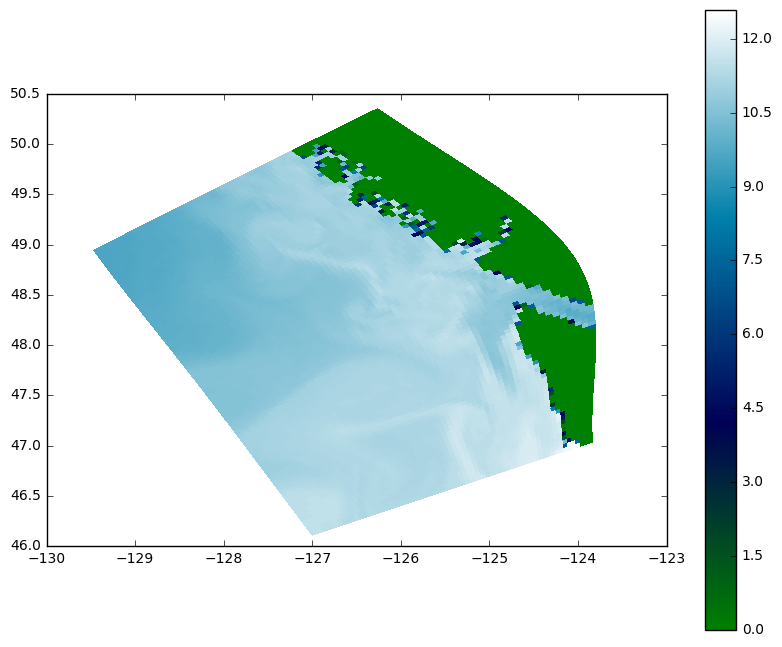

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi, gphit_wcvi,votemper_ic[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.show()

In [14]:
file_temp = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc', 'w', zlib=True)
# dataset attributes
nc_tools.init_dataset_attrs(
    file_temp, 
    title='Temperature and salinity Initial Condition', 
    notebook_name='Making_IC_from_JP', 
    nc_filepath='/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc',
    comment='Temperature and salinity from JP Model, preliminary_grid; used at all grid points')

file_temp.createDimension('xb', votemper_ic.shape[2]);
file_temp.createDimension('yb', votemper_ic.shape[1]);
file_temp.createDimension('deptht', votemper_ic.shape[0]);
file_temp.createDimension('time_counter', None);


nav_lat = file_temp.createVariable('nav_lat', 'float32', ('yb','xb'));
nav_lat.long_name = 'Latitude';
nav_lat.units = 'degrees_north';


nav_lon = file_temp.createVariable('nav_lon', 'float32', ('yb','xb'));
nav_lon.long_name = 'Longitude';
nav_lon.units = 'degrees_east';


deptht = file_temp.createVariable('deptht', 'float32', ('deptht'));
deptht.long_name = 'Vertical T Levels';
deptht.units = 'm';
deptht.positive = 'down';


time_counter = file_temp.createVariable('time_counter', 'float32', ('time_counter'));
time_counter.units = 's';
time_counter.long_name = 'time';
time_counter.calendar = 'noleap';


votemper = file_temp.createVariable('votemper', 'float32', ('time_counter','deptht','yb','xb'));
votemper.units = 'degC'
votemper.long_name = 'Temperature';
votemper.grid = 'WCVI';


vosaline = file_temp.createVariable('vosaline', 'float32', ('time_counter','deptht','yb','xb'));
vosaline.units = 'PSU';
vosaline.long_name = 'Practical Salinity';
vosaline.grid = 'WCVI';




nav_lat[:] = gphit_wcvi[:];
nav_lon[:] = glamt_wcvi[:];
deptht[:] = deptht_JP[:];
time_counter[0] = 1;
votemper[0,:] = votemper_ic[:]
vosaline[0,:]= vosaline_ic[:]

file_temp.close()





file format: NETCDF4
Conventions: CF-1.6
title: Temperature and salinity Initial Condition
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/canyonsubc/wcvi/src/tip/grid/Making_IC_from_JP.ipynb
references: REQUIRED
history: [2017-06-29 09:24:59] Created netCDF4 zlib=True dataset.
comment: Temperature and salinity from JP Model, preliminary_grid; used at all grid points


In [ ]:
votemper_ic.shape

In [ ]:
deptht.shape